In [1]:
# Imports and Data paths

import sys
import os
# Path追加
sys.path.append('../../')

import numpy as np
import cv2
import scipy.stats
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector
import configargparse
from typing import Any, Dict, List, Tuple, Optional
import warnings
from dataclasses import dataclass
from args import get_config
from data import Dataset
from common.visulaizations import draw_bb

import time
import globalflow as gflow

configs = get_config("-c ../../configs/mcftracker.ini")


In [2]:
model = init_detector(configs.config_file, configs.weight_file, device=configs.device)
confidence_th = 0.9
dataset = Dataset(configs.data_dir, configs.result_dir,  fps=configs.fps)

total_imgs = len(dataset)
detections = {}
tags = {}
images = {}
t2f = []
# Inference using the model
for idx in range(0, total_imgs):
    print(f"Processing : {idx} / {total_imgs}")
    img_id = f"{idx:04d}"
    # out_filename = os.path.join(configs.result_dir, f"{idx}.png")
    img = dataset.get_images(idx)
    result = inference_detector(model, img)
    class_dets = result[0]
    scores = class_dets[:, -1]
    class_dets = class_dets[scores>confidence_th,:]
    print(img_id)
    detections[img_id] = class_dets
    tags[img_id] = [a[0:4] for a in class_dets]
    images[img_id] = img
    t2f.append(img_id)

load checkpoint from local path: ../../weights/old.pth
Processing : 0 / 105


/root/miniconda3/lib/python3.9/site-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


0000
Processing : 1 / 105
0001
Processing : 2 / 105
0002
Processing : 3 / 105
0003
Processing : 4 / 105
0004
Processing : 5 / 105
0005
Processing : 6 / 105
0006
Processing : 7 / 105
0007
Processing : 8 / 105
0008
Processing : 9 / 105
0009
Processing : 10 / 105
0010
Processing : 11 / 105
0011
Processing : 12 / 105
0012
Processing : 13 / 105
0013
Processing : 14 / 105
0014
Processing : 15 / 105
0015
Processing : 16 / 105
0016
Processing : 17 / 105
0017
Processing : 18 / 105
0018
Processing : 19 / 105
0019
Processing : 20 / 105
0020
Processing : 21 / 105
0021
Processing : 22 / 105
0022
Processing : 23 / 105
0023
Processing : 24 / 105
0024
Processing : 25 / 105
0025
Processing : 26 / 105
0026
Processing : 27 / 105
0027
Processing : 28 / 105
0028
Processing : 29 / 105
0029
Processing : 30 / 105
0030
Processing : 31 / 105
0031
Processing : 32 / 105
0032
Processing : 33 / 105
0033
Processing : 34 / 105
0034
Processing : 35 / 105
0035
Processing : 36 / 105
0036
Processing : 37 / 105
0037
Proce

In [3]:
@dataclass(frozen=True)
class Detection:
    center: np.ndarray
    minc: np.ndarray
    maxc: np.ndarray
    area: float
    reid: Optional[np.ndarray] = None


@dataclass
class Stats:
    minc: np.ndarray
    maxc: np.ndarray
    num_max_det: int


def quiet_divide(a, b):
    """Quiet divide function that does not warn about (0 / 0)."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        return np.true_divide(a, b)

def calc_HS_histogram(image, roi):
    roi = [roi.minc[0], roi.minc[1], roi.maxc[0], roi.maxc[1]]
    roi = [int(a) for a in roi]
    cropped = image[roi[1]:roi[3], roi[0]:roi[2], :]
    hsv = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).flatten()
    return hist


def calc_bhattacharyya_distance(hist1, hist2):
	return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)


def boxiou(det1, det2):
    """Computes IOU of two rectangles. Taken from
    https://github.com/cheind/py-motmetrics/blob/6597e8a4ed398b9f14880fa76de26bc43d230836/motmetrics/distances.py#L64
    """
    a_min, a_max = det1.minc, det1.maxc
    b_min, b_max = det2.minc, det2.maxc
    # Compute intersection.
    i_min = np.maximum(a_min, b_min)
    i_max = np.minimum(a_max, b_max)
    i_size = np.maximum(i_max - i_min, 0)
    i_vol = np.prod(i_size, axis=-1)
    # Get volume of union.
    a_size = np.maximum(a_max - a_min, 0)
    b_size = np.maximum(b_max - b_min, 0)
    a_vol = np.prod(a_size, axis=-1)
    b_vol = np.prod(b_size, axis=-1)
    u_vol = a_vol + b_vol - i_vol
    return np.where(
        i_vol == 0, np.zeros_like(i_vol, dtype=float), quiet_divide(i_vol, u_vol)
    )


In [4]:
timeseries = []
fnames = []


stats = Stats(minc=np.array([1e3] * 2), maxc=np.array([-1e3] * 2), num_max_det=0)
for t, (fname, objs) in enumerate(detections.items()):
    fnames.append(fname)
    tdata = []

    for oidx, obj in enumerate(objs):
        minc = np.array([obj[0], obj[1]])
        maxc = np.array([obj[2], obj[3]])
        c = (minc + maxc) * 0.5
        area = (maxc[0] - minc[0]) * (maxc[1] - minc[1])

        tdata.append(Detection(c, minc, maxc, area))
        stats.minc = np.minimum(stats.minc, minc)
        stats.maxc = np.maximum(stats.maxc, maxc)
    timeseries.append(tdata)
    stats.num_max_det = max(stats.num_max_det, len(tdata))

class GraphCosts(gflow.StandardGraphCosts):
    def __init__(self):
        super().__init__(
            penter=1e-2,
            pexit=1e-4,
            beta=2e-2,
            max_obs_time=len(timeseries) - 1,
        )
        print("enter")

    def transition_cost(self, x: gflow.FlowNode, y: gflow.FlowNode) -> float:
        """Log-probability of pairing xi(t-1) with xj(t).
        Modelled by intersection over union downweighted by an
        exponential decreasing probability on the time-difference.
        """
        iou_logprob = np.log(boxiou(x.obs, y.obs) + 1e-8)
        tdiff = y.time_index - x.time_index
        tlogprob = scipy.stats.expon.logpdf(
            tdiff, loc=1.0, scale=1 / 1.0
        )
        hist1 = calc_HS_histogram(images[t2f[x.time_index]], x.obs)
        hist2 = calc_HS_histogram(images[t2f[y.time_index]], x.obs)
        prob_color = 1.0 - calc_bhattacharyya_distance(hist1, hist2)
        return -(iou_logprob)

flowgraph = gflow.build_flow_graph(
timeseries, GraphCosts(), num_skip_layers=3, cost_scale=1e4, max_cost=3e3
)
flowdict, _, _ = gflow.solve(flowgraph, (1, 20))
traj = gflow.find_trajectories(flowdict)
obs_to_traj = gflow.label_observations(timeseries, traj)
traj_info = [
    {"idx": tidx, "start": fnames[t[0].time_index], "end": fnames[t[-1].time_index]}
    for tidx, t in enumerate(traj)
]
# Use filenames instead of time indices
obs_to_traj = {fname: ids for fname, ids in zip(fnames, obs_to_traj)}
print(obs_to_traj, traj_info, stats)



enter
{'0000': [-1, 0, 1, 2, 3], '0001': [0, 1, 3, 2, -1], '0002': [0, 1, 3, 2], '0003': [1, 0, 3, 2], '0004': [1, 0, 3, 2], '0005': [1, 0, 2, 3, -1], '0006': [1, 0, 2, 3], '0007': [1, 0, 2], '0008': [1, 3, 2], '0009': [1, 0, 2, -1], '0010': [0, 1], '0011': [0, 1, 4, 2], '0012': [0, 3, 1, 4, 2], '0013': [4, 0, 2, 1, 3], '0014': [2, 3, 4, 1], '0015': [2, 0, 3, -1, 1], '0016': [2, 0, 3, 1, -1], '0017': [2, 0, 3], '0018': [0, 4, 3, 2, 5], '0019': [4, 0, 5, 3], '0020': [5, 0, 4, 3, 2], '0021': [5, 0, 2, 3, 4], '0022': [5, 0, 3, 2], '0023': [5, 2, 3, 4], '0024': [5, 0, 2, 3], '0025': [5, 4, 3, 2], '0026': [5, 4, 3, 2, -1], '0027': [5, 4, 3, 2, -1], '0028': [0, 5, 3, 2, -1], '0029': [5, 4, -1, 3, 2], '0030': [5, 4, 3, 2], '0031': [5, 0, 3, -1, 2], '0032': [5, 0, 2, 3], '0033': [5, 0, 3, 2], '0034': [5, 4, 3, 2], '0035': [5, 4, 3, 6, 2], '0036': [5, 4, 3, 6], '0037': [5, 0, 3, 2, 6], '0038': [4, 5, 3, 2, 6], '0039': [4, 5, 3, 6, 2], '0040': [4, 5, 3, -1, 2, 0, -1], '0041': [4, 5, 3, -1, 2], '

In [21]:
from common.visulaizations import draw_bb


palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)
def compute_color_for_labels(label):
    """
    Simple function that adds fixed color depending on the class
    """
    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)
def draw_boxes(img, bbox, identities=None, offset=(0,0)):
    for i,box in enumerate(bbox):
        x1,y1,x2,y2 = [int(i) for i in box]
        x1 += offset[0]
        x2 += offset[0]
        y1 += offset[1]
        y2 += offset[1]
        # box text and bar
        id = int(identities[i]) if identities is not None else 0    
        color = compute_color_for_labels(id)
        label = '{}{:d}'.format("", id)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 2 , 2)[0]
        cv2.rectangle(img,(x1, y1),(x2,y2),color,3)
        cv2.rectangle(img,(x1, y1),(x1+t_size[0]+3,y1+t_size[1]+4), color,-1)
        cv2.putText(img,label,(x1,y1+t_size[1]+4), cv2.FONT_HERSHEY_PLAIN, 2, [255,255,255], 2)
    return img

RESULT_DIR = "../../results/mcftracker"

# 書き込み設定
fourcc = cv2.VideoWriter_fourcc('m','p','4', 'v')
im_width = img.shape[1]
im_height = img.shape[0]
fps = 15

save_video_path = f"{RESULT_DIR}/results.mp4"

video = cv2.VideoWriter(filename=save_video_path,
                        fourcc=fourcc,
                        fps=fps,
                        frameSize=(int(im_width),int(im_height)))

for fname in images.keys():
    ids = obs_to_traj[fname]
    bbs = detections[fname]

    img = images[fname]
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlayed = draw_boxes(img, [[bb[0], bb[1], bb[2], bb[3]] for bb in bbs], ids)
    video.write(overlayed)
video.release()



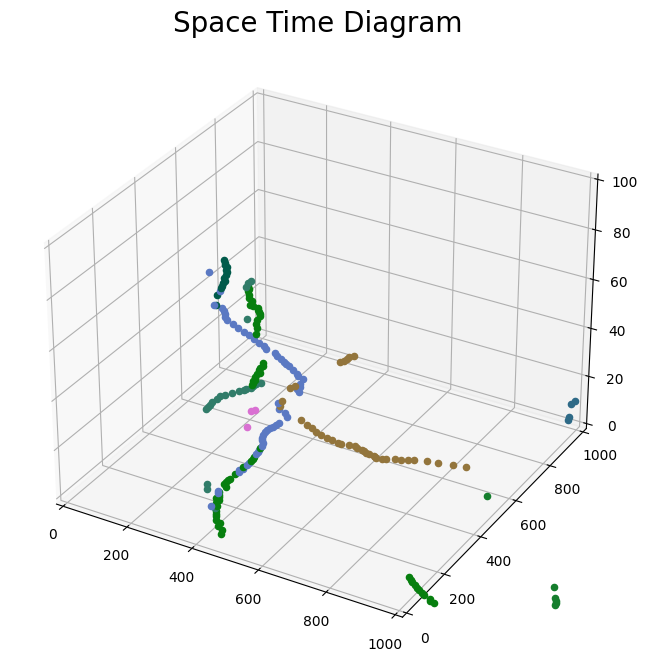

In [34]:
# TODO

# 1. loop through images keys
# 2. get detections 
# 3. plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Figureを追加
fig = plt.figure(figsize = (16, 8))

# 3DAxesを追加
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
# Axesのタイトルを設定
ax.set_title("Space Time Diagram", size = 20)
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
ax.set_zlim([0, 100])
ims = []
for t, fname in enumerate(images.keys()):
    ids = obs_to_traj[fname]
    bbs = detections[fname]
    centers = np.array([(bbs[:, 0] + bbs[:, 2]) / 2.0, (bbs[:, 1] + bbs[:, 3]) / 2.0])

    img = images[fname]
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlayed = draw_boxes(img, [[bb[0], bb[1], bb[2], bb[3]] for bb in bbs], ids)
    ax2.imshow(overlayed)
    for i in range(len(centers)):
        color = compute_color_for_labels(ids[i])
        color = [color[0]/255.0, color[1]/255.0, color[2]/255.0]
        ax.scatter(centers[0, i], centers[1, i], t, color = color)
    plt.savefig(f'../../results/mcftracker/images/{t}.png')

plt.show()